# Q1

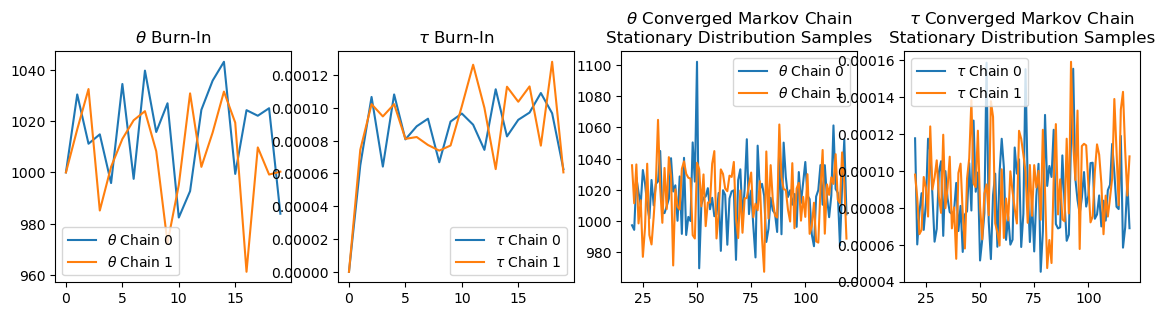

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

m = 1000
s = 100

n = 30; x = stats.norm(loc=m, scale=s).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau[c,g] = stats.gamma(a=n/2+1, scale=2/((x-theta[c,g-1])**2).sum()).rvs()
        
        theta[c,g] = stats.norm(x.mean(), scale=1/(tau[c,g]*n)**0.5).rvs()

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();
fig.show()

# Q2


### A) Derive the full conditional distributions $p(\tau|\theta, x)$ and $p(\theta|\tau, x)$ if $p(\theta)$ is $N(\theta_0, \tau_0)$ and $p(\tau) \propto \tau^{\frac{a}{2}-1}e^{\frac{-\lambda}{2}\tau}$
#### Prior Distributions:
- $p(\theta) \sim N(\theta_0, \tau_0^{-1})$, meaning  
  $$
  p(\theta) \propto \exp\left(-\frac{\tau_0}{2} (\theta - \theta_0)^2\right).
  $$  

- $p(\tau) \propto \tau^{\frac{a}{2}-1} e^{-\frac{\lambda}{2}\tau}$, corresponding to a gamma distribution with shape $\frac{a}{2}$ and rate $\frac{\lambda}{2}$.

#### Likelihood Function:
Assume $x_1, \dots, x_n \sim N(\theta, \tau^{-1})$, the likelihood is:
$$
p(x | \theta, \tau) \propto \tau^{n/2} \exp\left(-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2 \right).
$$

#### Posterior Full Conditionals:
##### For $\theta$:
Combine the prior and likelihood:
$$
p(\theta | \tau, x) \propto p(x | \theta, \tau) p(\theta),
$$
which gives:
$$
p(\theta | \tau, x) \propto \exp\left(-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2 - \frac{\tau_0}{2} (\theta - \theta_0)^2 \right).
$$
Group terms involving $\theta$ into a quadratic form:
$$
p(\theta | \tau, x) \propto \exp\left(-\frac{\tilde{\tau}}{2} (\theta - \tilde{\theta})^2 \right),
$$
where:
$$
\tilde{\tau} = \tau n + \tau_0, \quad \tilde{\theta} = \frac{\tau n \bar{x} + \tau_0 \theta_0}{\tilde{\tau}}.
$$
Hence:
$$
\theta | \tau, x \sim N(\tilde{\theta}, \tilde{\tau}^{-1}).
$$

##### For $\tau$:
Combine the prior and likelihood:
$$
p(\tau | \theta, x) \propto p(x | \theta, \tau) p(\tau),
$$
which gives:
$$
p(\tau | \theta, x) \propto \tau^{n/2} \exp\left(-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2 \right) \cdot \tau^{\frac{a}{2}-1} \exp\left(-\frac{\lambda}{2} \tau \right).
$$
Combine powers of $\tau$ and exponents:
$$
p(\tau | \theta, x) \propto \tau^{\frac{n+a}{2}-1} \exp\left(-\frac{\tau}{2} \left(S + \lambda \right)\right),
$$
where $S = \sum_{i=1}^n (x_i - \theta)^2$.
Thus:
$$
\tau | \theta, x \sim \text{Gamma}\left(\frac{n + a}{2}, \frac{S + \lambda}{2}\right).
$$

### B) Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?

- $\alpha = a/2$ controls the weight of the prior relative to the data, effectively representing the number of prior observations (pseudocounts). A larger $\alpha$ implies the prior contributes more strongly to the posterior.
- $\lambda$ determines the prior's precision, influencing how tightly it is concentrated around a particular value. A larger $\lambda$ means the prior is highly informative, reducing the posterior's dependence on the data.

### D) Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.
- Generate synthetic data $x_1, \dots, x_n \sim N(\mu, \sigma^2)$ for fixed $\mu$ and $\sigma^2$.
- Use different values of $a$ and $\lambda$ (e.g., small, moderate, and large).
- Run the Gibbs sampler and plot:
    - Posterior samples of $\theta$ and $\tau$.
    - Posterior densities.
- Observations:
    - **Small $a$, $\lambda$:** The posterior depends more on the data, leading to wider posterior distributions.
    - **Large $a$, $\lambda$:** The prior dominates, shrinking the posterior distribution around the prior mean and precision.
inates, shrinking the posterior distribution around the prior mean and precision.
inates, shrinking the posterior distribution around the prior mean and precision.


## Q2 C) Create an updated version of the Gibbs sampler for $N(\theta_0, \tau_0)$ and gamma(shape= $\frac{a}{2}$, rate=$\frac{\lambda}{2}$) and priors $p(\theta)$, $p(\tau)$ respectively

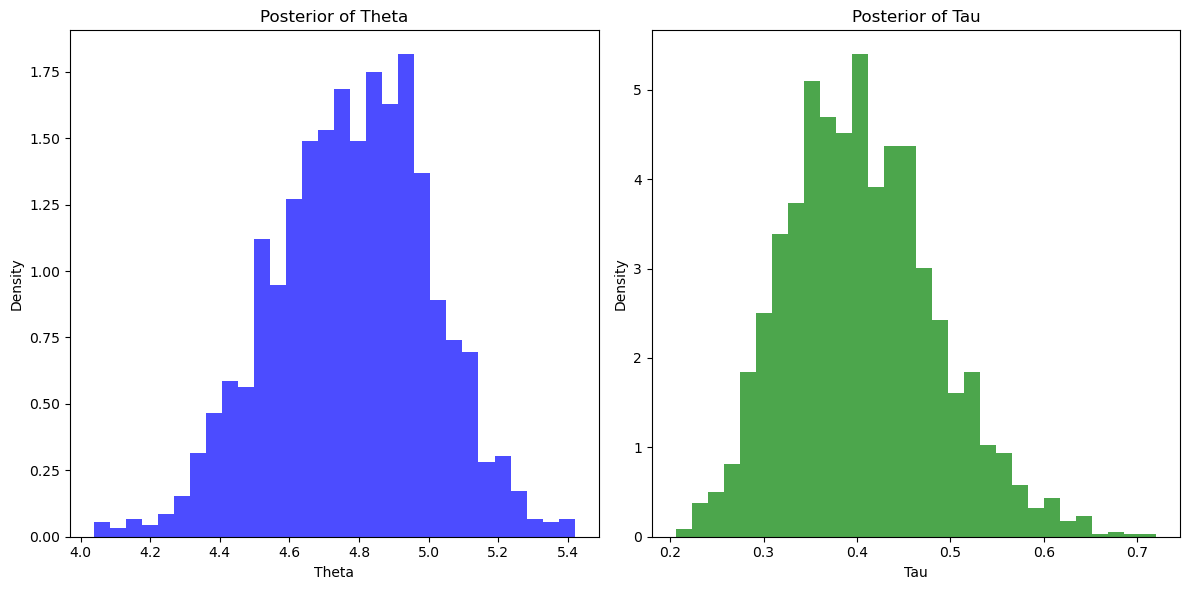

In [9]:
import numpy as np
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt

def gibbs_sampler_updated(theta0, tau0, a, lambda_, x, num_iter=1000):

    n = len(x)
    
    theta = np.mean(x)
    tau = 1 / np.var(x)

    theta_samples = []
    tau_samples = []

    for _ in range(num_iter):
        tau_theta = tau * n + tau0
        mean_theta = (tau * n * np.mean(x) + tau0 * theta0) / tau_theta
        theta = np.random.normal(mean_theta, np.sqrt(1 / tau_theta))
        
        S = np.sum((x - theta)**2)
        shape = (n + a) / 2
        rate = (S + lambda_) / 2
        tau = np.random.gamma(shape, 1 / rate)

        theta_samples.append(theta)
        tau_samples.append(tau)

    return np.array(theta_samples), np.array(tau_samples)


np.random.seed(20)

true_mu = 5
true_sigma2 = 2
n = 50
x = np.random.normal(true_mu, np.sqrt(true_sigma2), n)

theta0 = 0
tau0 = 1
a = 2
lambda_ = 1

num_iter = 2000
theta_samples, tau_samples = gibbs_sampler_updated(theta0, tau0, a, lambda_, x, num_iter)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(theta_samples, bins=30, density=True, alpha=0.7, color='blue')
plt.title("Posterior of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")

plt.subplot(1, 2, 2)
plt.hist(tau_samples, bins=30, density=True, alpha=0.7, color='green')
plt.title("Posterior of Tau")
plt.xlabel("Tau")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


## Q2 D) Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood

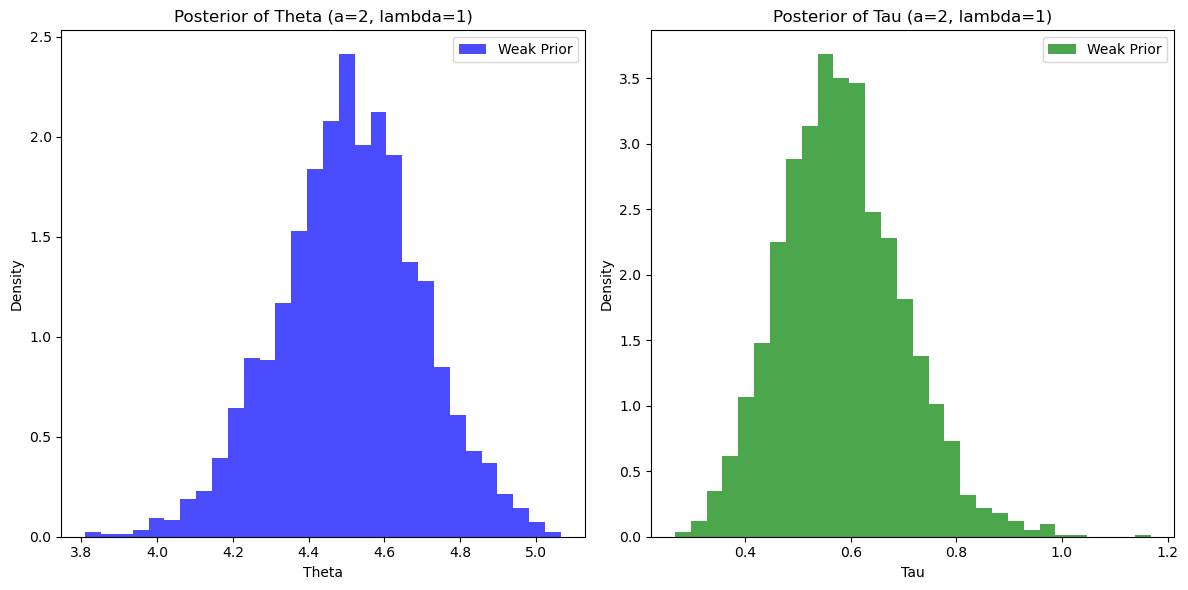

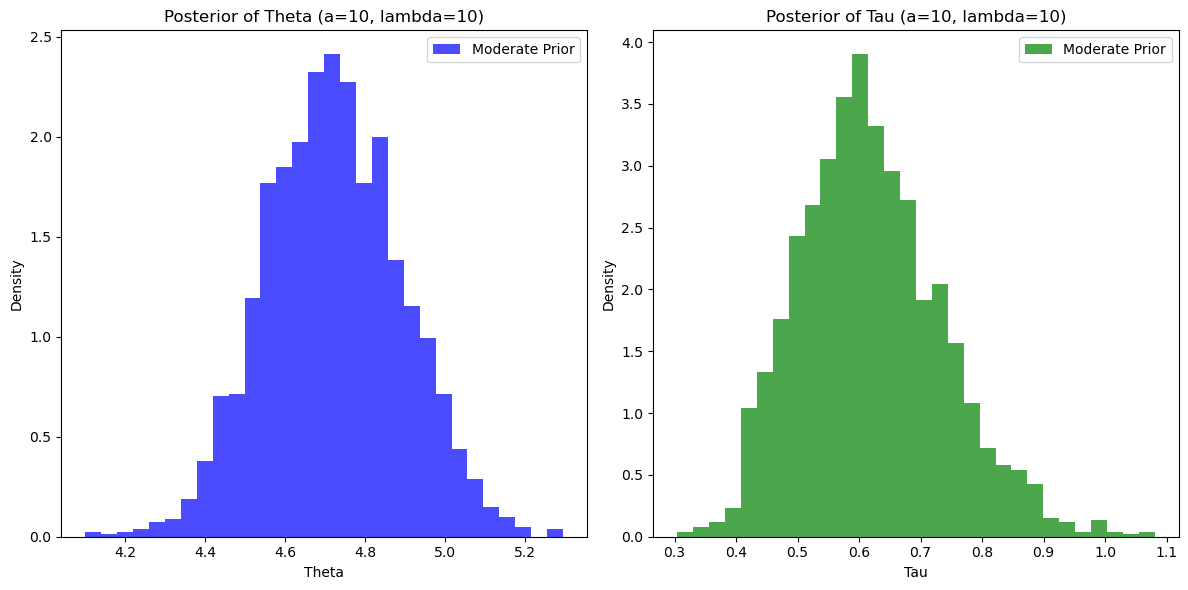

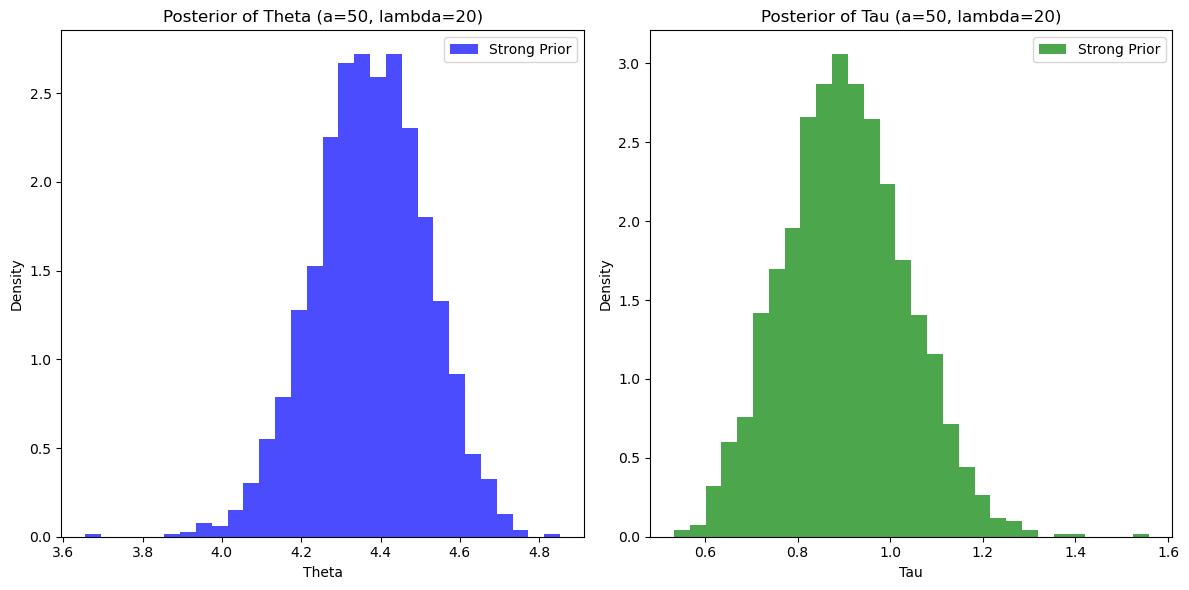

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

def gibbs_sampler(theta0, tau0, a, lambda_, x, num_iter=1000):

    n = len(x)
    
    theta = np.mean(x)
    tau = 1 / np.var(x)

    theta_samples = []
    tau_samples = []

    for _ in range(num_iter):
        tau_theta = tau * n + tau0
        mean_theta = (tau * n * np.mean(x) + tau0 * theta0) / tau_theta
        theta = np.random.normal(mean_theta, np.sqrt(1 / tau_theta))
        
        S = np.sum((x - theta)**2)
        shape = (n + a) / 2
        rate = (S + lambda_) / 2
        tau = np.random.gamma(shape, 1 / rate)

        theta_samples.append(theta)
        tau_samples.append(tau)

    return np.array(theta_samples), np.array(tau_samples)

np.random.seed(42)
true_mu = 5
true_sigma2 = 2
n = 50
x = np.random.normal(true_mu, np.sqrt(true_sigma2), n)


def plot_results(theta_samples, tau_samples, a, lambda_, label):
    plt.figure(figsize=(12, 6))

    # Posterior for theta
    plt.subplot(1, 2, 1)
    plt.hist(theta_samples, bins=30, density=True, alpha=0.7, color='blue', label=label)
    plt.title(f"Posterior of Theta (a={a}, lambda={lambda_})")
    plt.xlabel("Theta")
    plt.ylabel("Density")
    plt.legend()

    # Posterior for tau
    plt.subplot(1, 2, 2)
    plt.hist(tau_samples, bins=30, density=True, alpha=0.7, color='green', label=label)
    plt.title(f"Posterior of Tau (a={a}, lambda={lambda_})")
    plt.xlabel("Tau")
    plt.ylabel("Density")
    plt.legend()

    plt.tight_layout()
    plt.show()

hyperparameter_sets = [
    {'theta0': 0, 'tau0': 1, 'a': 2, 'lambda_': 1, 'label': 'Weak Prior'},
    {'theta0': 5, 'tau0': 5, 'a': 10, 'lambda_': 10, 'label': 'Moderate Prior'},
    {'theta0': 3, 'tau0': 10, 'a': 50, 'lambda_': 20, 'label': 'Strong Prior'}
]

for params in hyperparameter_sets:
    theta_samples, tau_samples = gibbs_sampler(
        theta0=params['theta0'],
        tau0=params['tau0'],
        a=params['a'],
        lambda_=params['lambda_'],
        x=x,
        num_iter=2000
    )
    plot_results(theta_samples, tau_samples, params['a'], params['lambda_'], params['label'])


#### Q3 Read the following "conversation". My reactions to this initial text I was provied with are the colored font. Then either (A) provide an analagous derivation of this result for the multinomial-Dirichlet specification, or (B) just report that if the prior is a proper distribution then the posterior is proportional to the joint distribution as Bayes Theorem tells us and describe how one might therefore identify the exact distribution of the posterior by just looking at the joint but that finally all this is moot and beside the point because as Bayesians we're going to trade any functional forms of distributions for samples from those distributions to just make histograms and belief (credible interval probability) statements based on those anyway...

We have learned that the posterior is proportional to the joint distribution based on Bayes Theorem. Since the two are proportional, we can infer the distribution of the posterior using the joint distribution and as Bayesians, we only care about kernel of the distribution, so we can just determine the distribution of the posterior based simply upon the joint distribution. However, even this is irrelevant as we trade any form of distributions for samples from the distributions to create histograms and belief statements based on the samples
